In [22]:
import numpy as np
import pandas as pd
import scipy as sp
import yfinance as yf
import pypfopt
import matplotlib.pyplot as plt
import fear_and_greed

from pypfopt import black_litterman, plotting, objective_functions
from pypfopt import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier

In [5]:
tickers = ["TSLA", "NVDA", "AMZN", "META", "MSFT", "AAPL", "AMD"] # Initial asset universe
start_date = '2013-01-01'
end_date = '2024-01-01'

In [6]:
data = yf.download(tickers, start=start_date, end=end_date)

print(data.head())
closing_prices = data["Adj Close"]
closing_prices.head(10)

returns = np.log(closing_prices / closing_prices.shift(1).dropna())

market_prices = yf.download("VOO", start=start_date, end=end_date)["Adj Close"]

market_caps = {}

for ticker in tickers:
    stock = yf.Ticker(ticker)
    market_caps[ticker] = stock.info["marketCap"]

[*********************100%***********************]  7 of 7 completed


Price                      Adj Close                                       \
Ticker                          AAPL   AMD     AMZN       META       MSFT   
Date                                                                        
2013-01-02 00:00:00+00:00  16.705706  2.53  12.8655  27.915949  22.451807   
2013-01-03 00:00:00+00:00  16.494839  2.49  12.9240  27.686640  22.151049   
2013-01-04 00:00:00+00:00  16.035374  2.59  12.9575  28.673666  21.736473   
2013-01-07 00:00:00+00:00  15.941056  2.67  13.4230  29.331686  21.695833   
2013-01-08 00:00:00+00:00  15.983956  2.67  13.3190  28.972765  21.582026   

Price                                              Close                 ...  \
Ticker                         NVDA      TSLA       AAPL   AMD     AMZN  ...   
Date                                                                     ...   
2013-01-02 00:00:00+00:00  0.293535  2.357333  19.608213  2.53  12.8655  ...   
2013-01-03 00:00:00+00:00  0.293766  2.318000  19.360714  2.49 

[*********************100%***********************]  1 of 1 completed


<Axes: >

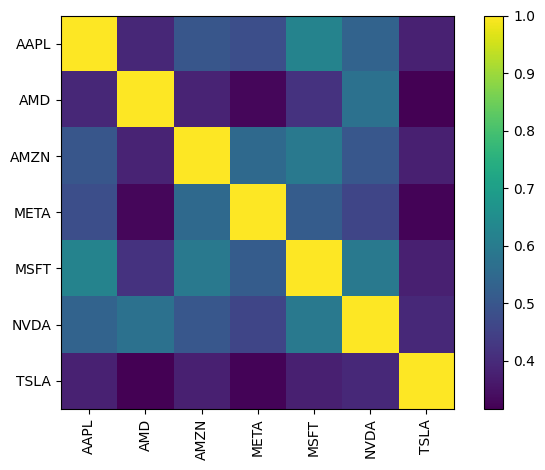

In [7]:
covariance_matrix = returns.cov()
plotting.plot_covariance(covariance_matrix, plot_correlation=True)

In [8]:
delta = black_litterman.market_implied_risk_aversion(market_prices)
prior = black_litterman.market_implied_prior_returns(market_caps, delta, covariance_matrix)

print(f"Delta: {delta}")
print(f"Priors: {prior}")

Delta: 4.088019988131726
Priors: Ticker
AAPL    0.020994
AMD     0.021467
AMZN    0.021075
META    0.021166
MSFT    0.020976
NVDA    0.021671
TSLA    0.021404
dtype: float64


<Axes: ylabel='Ticker'>

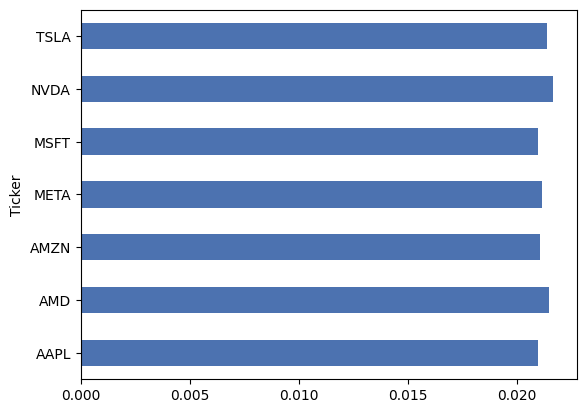

In [9]:
prior.plot.barh()

In [10]:
view_dict = {"TSLA": 0.04, "NVDA": 0.08, "AMZN": 0.03, "META": 0.02, "MSFT": 0.04, "AAPL": 0.05, "AMD": 0.07} # Absolute views

view_confidences = [0.3, 0.9, 0.4, 0.5, 0.2, 0.6, 0.7, 0.8]

bl = BlackLittermanModel(covariance_matrix, pi=prior, absolute_views=view_dict, view_confidences=view_confidences)

In [24]:
# get fear/greed current values - need to integrate into investor views
# to see whether sentiment has an effect on bl output
# 0-25 extremne fear
# 26-50 fear
# 51-75 greed
# 76-100 extreme greed
test_FG = fear_and_greed.get()

print(test_FG)


# as FG is general indicator of stock market, could potentially mirror these indicators for each stock specifically
# then use that to form the adjusted view

FearGreedIndex(value=48.8, description='neutral', last_update=datetime.datetime(2024, 11, 1, 23, 59, 56, tzinfo=datetime.timezone.utc))


In [29]:
# get indiv FG indicators here (split into separeate file later)

# market momentum - use Relative Strength Index (RSI) for this
# overbought conditions (e.g., RSI > 70) = greed
# oversold conditions (e.g., RSI < 30) =  fear

def calculate_indiv_rsi(ticker: str, period: int = 14, start_date: str = "2023-01-01", end_date: str = "2024-01-01"):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    stock_data['Change'] = stock_data['Close'].diff() # for daily price change

    stock_data['Gain'] = stock_data['Change'].apply(lambda x: x if x > 0 else 0)
    stock_data['Loss'] = stock_data['Change'].apply(lambda x: -x if x < 0 else 0)

    stock_data['Avg_Gain'] = stock_data['Gain'].rolling(window=period, min_periods=1).mean()
    stock_data['Avg_Loss'] = stock_data['Loss'].rolling(window=period, min_periods=1).mean()

    stock_data['RS'] = stock_data['Avg_Gain'] / stock_data['Avg_Loss']

    stock_data['RSI'] = 100 - (100 / (1 + stock_data['RS'])) # calculate RSI

    result = stock_data[['Close', 'RSI']].dropna()
    return result

def plot_rsi(ticker: str, start_date: str = "2023-01-01", end_date: str = "2024-01-01"):
    rsi_data = calculate_indiv_rsi(ticker, start_date=start_date, end_date=end_date)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    fig.suptitle(f'{ticker} Price and RSI')
    
    ax2.plot(rsi_data.index, rsi_data['RSI'], label='RSI', color='purple')
    ax2.axhline(70, color='red', linestyle='--', label='Overbought (70)')
    ax2.axhline(30, color='green', linestyle='--', label='Oversold (30)')
    ax2.set_ylabel('RSI')
    ax2.set_xlabel('Date')
    ax2.legend(loc='upper left')
    
    plt.show()

[*********************100%***********************]  1 of 1 completed

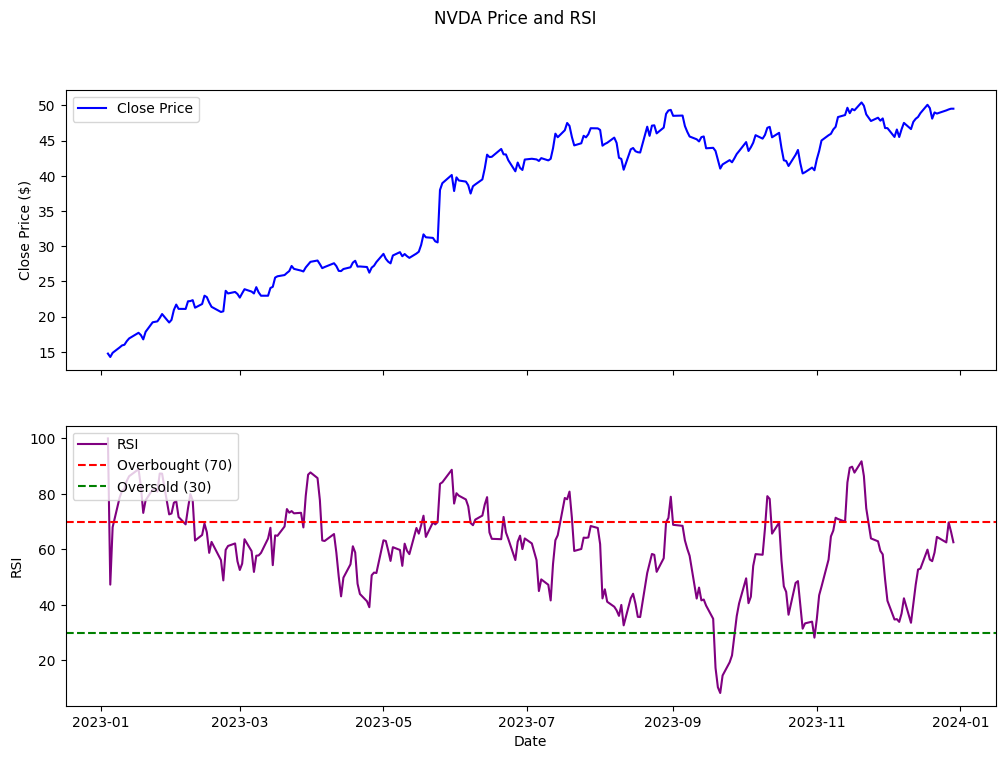

In [30]:
# rsi_data = calculate_indiv_rsi('NVDA')
plot_rsi('NVDA')

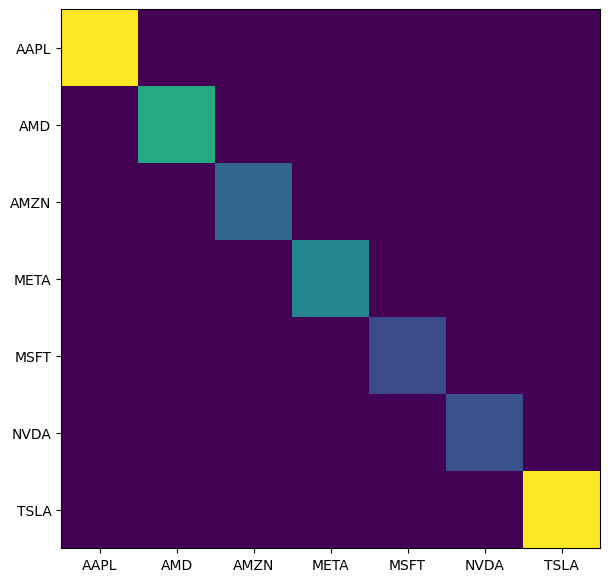

In [11]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [12]:
np.diag(bl.omega)

array([6.36894890e-05, 3.89966327e-05, 2.10670593e-05, 2.92956271e-05,
       1.43178074e-05, 1.60304670e-05, 6.36971609e-05])

In [13]:
# Calculate posterior returns

bl = BlackLittermanModel(covariance_matrix, pi="market", market_caps=market_caps, risk_aversion=delta, absolute_views=view_dict, omega=bl.omega)

bl_returns = bl.bl_returns()
bl_returns

Ticker
AAPL    0.033709
AMD     0.054650
AMZN    0.028569
META    0.026747
MSFT    0.030657
NVDA    0.054599
TSLA    0.038298
dtype: float64

In [14]:
returns_df = pd.DataFrame([prior, bl_returns, pd.Series(view_dict)], index=["Prior", "Posterior", "Views"]).T
returns_df

,Prior,Posterior,Views
AAPL,0.020994,0.033709,0.05
AMD,0.021467,0.054650,0.07
AMZN,0.021075,0.028569,0.03
META,0.021166,0.026747,0.02
MSFT,0.020976,0.030657,0.04
NVDA,0.021671,0.054599,0.08
TSLA,0.021404,0.038298,0.04


<Axes: >

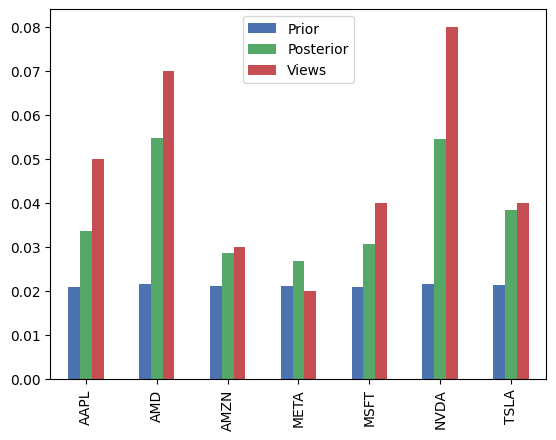

In [15]:
returns_df.plot.bar()

<Axes: >

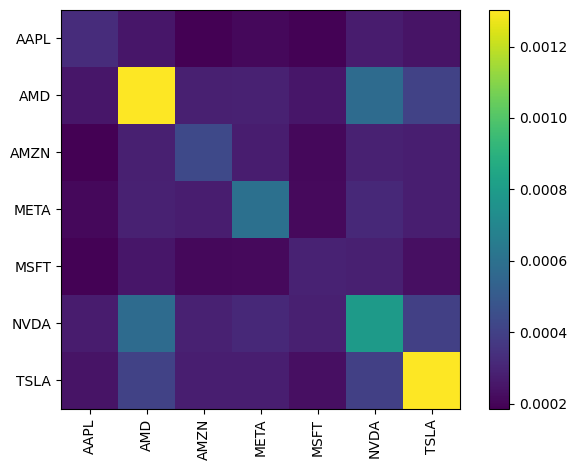

In [16]:
# posterior covariance matrix

posterior_cov = bl.bl_cov()
plotting.plot_covariance(posterior_cov)

In [18]:
efficient_frontier = EfficientFrontier(bl_returns, posterior_cov)
efficient_frontier.add_objective(objective_functions.L2_reg)
efficient_frontier.max_sharpe()
weights = efficient_frontier.clean_weights()
weights

AttributeError: module 'cvxpy' has no attribute 'constraints'

In [19]:
pd.Series(weights).plot.pie()

NameError: name 'weights' is not defined